# OLA - Ensemble Learning Business Case
## The company’s perspective:
* Ola is a leading ride-sharing platform, aiming to provide reliable, affordable, and
convenient urban transportation for everyone.
* The constant challenge Ola faces is the churn rate of its drivers. Ensuring driver
loyalty and reducing attrition are crucial to the company's operation.
* Analyzing driver data can reveal patterns in driver behavior, performance, and
satisfaction. This would help in foreseeing potential churn, allowing proactive
measures.
* By leveraging data science and ensemble learning, Ola can predict driver churn,
which would be pivotal in its driver retention strategy.


## Dataset Explanation: ola_driver.csv
1. MMMM-YY: Reporting month and year.
2. Driver_ID: A unique identifier for every driver.
3. Age: Age of the driver.
4. Gender: Driver's gender. Male: 0, Female: 1.
5. City: City code representing the city the driver operates in.
6. Education_Level: Education level of the driver, categorized into 0 for 10+, 1 for 12+, and 2 for graduate.
7. Income: Average monthly income of the driver.
8. Date Of Joining: The date when the driver joined Ola.
9. LastWorkingDate: The most recent or final day the driver worked with Ola.
10. Joining Designation: Designation of the driver at the onset of their journey with Ola.
11. Grade: A grade assigned to the driver at the reporting time, likely denoting performance or other metrics.
12. Total Business Value: The total monetary value (business) a driver brings in a month. Negative values might indicate cancellations, refunds, or other financial adjustments.
13. Quarterly Rating: Rating assigned to drivers on a quarterly basis. Ratings range from 1 to 5, with 5 being the best.

## Problem Statement?
    Assuming you are a data scientist at Ola, you are entrusted with the responsibility of analyzing the dataset to predict driver attrition (reduction). Our primary goal is to utilize ensemble learning techniques, evaluate the performance of your models, and provide actionable insights to reduce driver churn

In [56]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import roc_auc_score, roc_curve

import time
import warnings

# Settings the warnings to be ignored
warnings.filterwarnings("ignore")

##load jupyter black
import jupyter_black

jupyter_black.load()

In [57]:
path = "C:\Ankit\DL_Specialization\my_Practice\datasets\ola_driver.txt"
df = pd.read_csv(path)
##
df.drop("Unnamed: 0", axis="columns", inplace=True)
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


## Exploratory data analysis

In [58]:
df.info()
## Observation :
# 1. null value can be seen in many columns.
# 2. certain column are not in their format.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


LastWorkingDate         91.541039
Age                      0.319305
Gender                   0.272194
MMM-YY                   0.000000
Driver_ID                0.000000
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

<Axes: title={'center': 'Null value praportions'}>

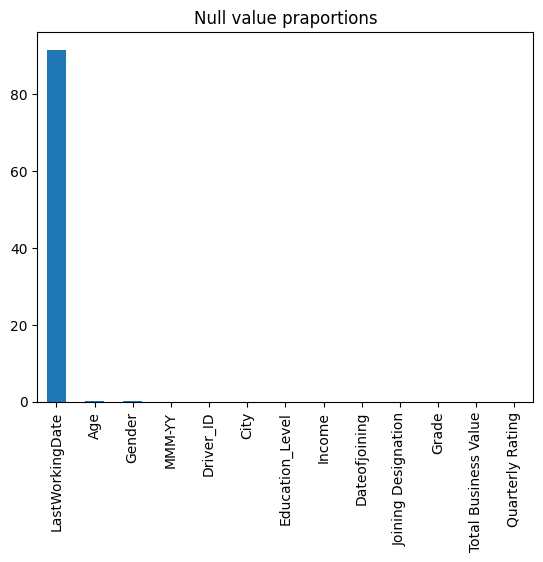

In [59]:
def check_null_praportions(data):
    return ((data.isnull().sum() / len(data)) * 100).sort_values(ascending=False)


## Praportions of Null values in each column
display(
    check_null_praportions(df),
    check_null_praportions(df).plot(kind="bar", title="Null value praportions"),
)

# Observations:
# 1. LastWorkingDate is null for 91% of drivers.This means most of them are working.
# 2. Age and Gender have NULL values

In [60]:
## get shape
df.shape
# observation:
# 1. their are 190104 rows in dataframe
# 2. Their are 13 features

(19104, 13)

Total Business Value    10181
Income                   2383
Driver_ID                2381
Dateofjoining             869
LastWorkingDate           493
Age                        36
City                       29
MMM-YY                     24
Joining Designation         5
Grade                       5
Quarterly Rating            4
Education_Level             3
Gender                      2
dtype: int64

<Axes: title={'center': 'Nunique values'}>

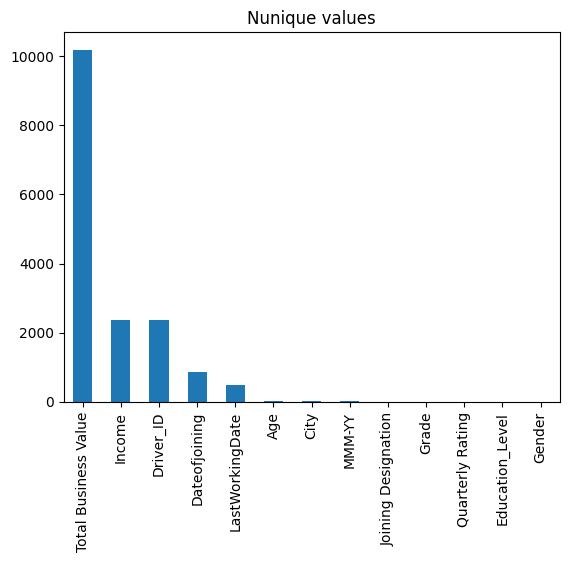

In [61]:
# get unique values
display(
    df.nunique().sort_values(ascending=False),
    df.nunique().sort_values(ascending=False).plot(kind="bar", title="Nunique values"),
)

# obesravations
# 1. Data of 2381 drivers is present.
# 2. Data from 29 city is available

In [62]:
# Change data types of various columns
df["MMM-YY"] = pd.to_datetime(df["MMM-YY"])
df["Dateofjoining"] = pd.to_datetime(df["Dateofjoining"])
df["LastWorkingDate"] = pd.to_datetime(df["LastWorkingDate"])

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [64]:
df.describe()

,MMM-YY,Driver_ID,Age,Gender,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,2019-12-11 02:09:29.849246464,1415.591133,34.668435,0.418749,1.021671,65652.025126,2018-04-28 20:52:54.874371840,2019-12-21 20:59:06.534653696,1.690536,2.252670,5.716621e+05,2.008899
min,2019-01-01 00:00:00,1.000000,21.000000,0.000000,0.000000,10747.000000,2013-04-01 00:00:00,2018-12-31 00:00:00,1.000000,1.000000,-6.000000e+06,1.000000
25%,2019-06-01 00:00:00,710.000000,30.000000,0.000000,0.000000,42383.000000,2016-11-29 12:00:00,2019-06-06 00:00:00,1.000000,1.000000,0.000000e+00,1.000000
50%,2019-12-01 00:00:00,1417.000000,34.000000,0.000000,1.000000,60087.000000,2018-09-12 00:00:00,2019-12-20 12:00:00,1.000000,2.000000,2.500000e+05,2.000000
75%,2020-07-01 00:00:00,2137.000000,39.000000,1.000000,2.000000,83969.000000,2019-11-05 00:00:00,2020-07-03 00:00:00,2.000000,3.000000,6.997000e+05,3.000000
max,2020-12-01 00:00:00,2788.000000,58.000000,1.000000,2.000000,188418.000000,2020-12-28 00:00:00,2020-12-28 00:00:00,5.000000,5.000000,3.374772e+07,4.000000
std,NaN,810.705321,6.257912,0.493367,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832


In [65]:
def knn_imputer(data):
    """
    Impute missing values and return imputed data frame
    """
    ## get all columns with integers or float
    num_vars = df.select_dtypes(np.number)
    num_vars.drop(["Driver_ID"], axis=1, inplace=True)
    imputer = KNNImputer(n_neighbors=5, weights="uniform", metric="nan_euclidean")
    data_new = imputer.fit_transform(num_vars)
    data_new = pd.DataFrame(data_new)
    data_new.columns = num_vars.columns
    return data_new

In [66]:
new_df = knn_imputer(df)

In [67]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   19104 non-null  float64
 1   Gender                19104 non-null  float64
 2   Education_Level       19104 non-null  float64
 3   Income                19104 non-null  float64
 4   Joining Designation   19104 non-null  float64
 5   Grade                 19104 non-null  float64
 6   Total Business Value  19104 non-null  float64
 7   Quarterly Rating      19104 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


In [68]:
## now concatinate imputed dataframe with remaining column
all_columns = set(df.columns)
imputed_columns = set(new_df.columns)
remaining_columns = list(all_columns.difference(imputed_columns))

In [69]:
new_df = pd.concat([new_df, df[remaining_columns]], axis=1)

LastWorkingDate         91.541039
Age                      0.000000
Gender                   0.000000
Education_Level          0.000000
Income                   0.000000
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
Driver_ID                0.000000
MMM-YY                   0.000000
Dateofjoining            0.000000
City                     0.000000
dtype: float64

<Axes: title={'center': 'Distribution :  Post removal of Null values'}>

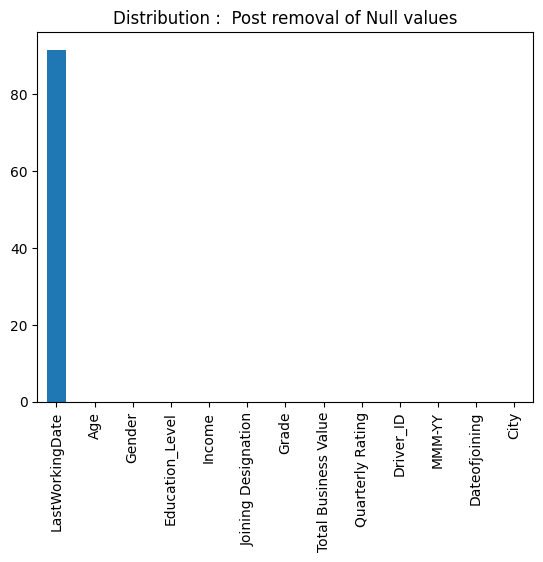

In [70]:
display(
    (new_df.isnull().sum() / len(new_df) * 100).sort_values(ascending=False),
    (new_df.isnull().sum() / len(new_df) * 100)
    .sort_values(ascending=False)
    .plot(kind="bar", title="Distribution :  Post removal of Null values"),
)

## Data preprocessing


### 1. Feature Engineering

In [71]:
agg_functions = {
    "Age": "max",
    "Gender": "first",
    "Education_Level": "last",
    "Income": "last",
    "Joining Designation": "last",
    "Grade": "last",
    "Total Business Value": "sum",
    "Quarterly Rating": "last",
    "LastWorkingDate": "last",
    "City": "first",
    "Dateofjoining": "last",
}

In [72]:
processed_df = (
    new_df.groupby(["Driver_ID", "MMM-YY"])
    .aggregate(agg_functions)
    .sort_index(ascending=[True, True])
)

In [73]:
processed_df.head()

Age  Gender  Education_Level   Income  \
Driver_ID MMM-YY                                               
1         2019-01-01  28.0     0.0              2.0  57387.0   
          2019-02-01  28.0     0.0              2.0  57387.0   
          2019-03-01  28.0     0.0              2.0  57387.0   
2         2020-11-01  31.0     0.0              2.0  67016.0   
          2020-12-01  31.0     0.0              2.0  67016.0   

                      Joining Designation  Grade  Total Business Value  \
Driver_ID MMM-YY                                                         
1         2019-01-01                  1.0    1.0             2381060.0   
          2019-02-01                  1.0    1.0             -665480.0   
          2019-03-01                  1.0    1.0                   0.0   
2         2020-11-01                  2.0    2.0                   0.0   
          2020-12-01                  2.0    2.0                   0.0   

                      Quarterly Rating LastWorkingDate City Dateofjoining  
Driver_ID MMM-YY                                                           
1         2019-01-01               2.0             NaT  C23    2018-12-24  
          2019-02-01               2.0             NaT  C23    2018-12-24  
          2019-03-01               2.0      2019-03-11  C23    2018-12-24  
2         2020-11-01               1.0             NaT   C7    2020-11-06  
          2020-12-01               1.0             NaT   C7    2020-11-06

In [74]:
final_data = pd.DataFrame()
final_data["Driver_ID"] = new_df["Driver_ID"].unique()

In [75]:
## Based on "Driver_ID", create aggregated columns based on ccertain operations.

final_data["Age"] = list(processed_df.groupby("Driver_ID", axis=0).max("MMM-YY")["Age"])
final_data["Gender"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Gender": "last"})["Gender"]
)
final_data["Education_Level"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Education_Level": "last"})[
        "Education_Level"
    ]
)
final_data["Income"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Income": "last"})["Income"]
)
final_data["Joining Designation"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Joining Designation": "last"})[
        "Joining Designation"
    ]
)
final_data["Grade"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Grade": "last"})["Grade"]
)
final_data["Total Business Value"] = list(
    processed_df.groupby("Driver_ID", axis=0).sum("Total Business Value")[
        "Total Business Value"
    ]
)

final_data["Quarterly Rating"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Quarterly Rating": "last"})[
        "Quarterly Rating"
    ]
)

# final_data["LastWorkingDate"] = list(
#     processed_df.groupby("Driver_ID", axis=0).agg({"LastWorkingDate": "last"})[
#         "LastWorkingDate"
#     ]
# )

final_data["City"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"City": "last"})["City"]
)

# final_data["Dateofjoining"] = list(
#     processed_df.groupby("Driver_ID", axis=0).agg({"Dateofjoining": "last"})[
#         "Dateofjoining"
#     ]
# )

final_data["Last_Quarterly_Rating"] = list(
    processed_df.groupby("Driver_ID", axis=0).agg({"Quarterly Rating": "last"})[
        "Quarterly Rating"
    ]
)

In [76]:
final_data.head()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,City,Last_Quarterly_Rating
0,1,28.0,0.0,2.0,57387.0,1.0,1.0,1715580.0,2.0,C23,2.0
1,2,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,C7,1.0
2,4,43.0,0.0,2.0,65603.0,2.0,2.0,350000.0,1.0,C13,1.0
3,5,29.0,0.0,0.0,46368.0,1.0,1.0,120360.0,1.0,C9,1.0
4,6,31.0,1.0,1.0,78728.0,3.0,3.0,1265000.0,2.0,C11,2.0


In [77]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Driver_ID              2381 non-null   int64  
 1   Age                    2381 non-null   float64
 2   Gender                 2381 non-null   float64
 3   Education_Level        2381 non-null   float64
 4   Income                 2381 non-null   float64
 5   Joining Designation    2381 non-null   float64
 6   Grade                  2381 non-null   float64
 7   Total Business Value   2381 non-null   float64
 8   Quarterly Rating       2381 non-null   float64
 9   City                   2381 non-null   object 
 10  Last_Quarterly_Rating  2381 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 204.7+ KB


In [78]:
final_data.describe()
## Observations :
# 1. Average Age of driver is 33 years.
# 2. Average Income of driver is 59334 INR/month.

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Last_Quarterly_Rating
count,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000
mean,1397.559009,33.770181,0.410584,1.00756,59334.157077,1.820244,2.096598,4.586742e+06,1.427971,1.427971
std,806.161628,5.933265,0.491496,0.81629,28383.666384,0.841433,0.941522,9.127115e+06,0.809839,0.809839
min,1.000000,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,1.000000
25%,695.000000,30.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,1.000000
50%,1400.000000,33.000000,0.000000,1.00000,55315.000000,2.000000,2.000000,8.176800e+05,1.000000,1.000000
75%,2100.000000,37.000000,1.000000,2.00000,75986.000000,2.000000,3.000000,4.173650e+06,2.000000,2.000000
max,2788.000000,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,4.000000,4.000000


### 2. Create new features from Existing features

In [79]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Driver_ID              2381 non-null   int64  
 1   Age                    2381 non-null   float64
 2   Gender                 2381 non-null   float64
 3   Education_Level        2381 non-null   float64
 4   Income                 2381 non-null   float64
 5   Joining Designation    2381 non-null   float64
 6   Grade                  2381 non-null   float64
 7   Total Business Value   2381 non-null   float64
 8   Quarterly Rating       2381 non-null   float64
 9   City                   2381 non-null   object 
 10  Last_Quarterly_Rating  2381 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 204.7+ KB


#### Check for quaterly rating of Driver, If the quaterly rating has inceased than we assign it as 1 otherwise 0.

In [80]:
##get first quater rating
first_quater = (
    processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "first"}).reset_index()
)
##get last quater rating
last_quater = (
    processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "last"}).reset_index()
)


rating_change_lst = []
## Based on first and last quater rating, asign 1 and O.
for (i, first), (j, second) in zip(first_quater.iterrows(), last_quater.iterrows()):
    # print(
    #     f"For Driver-id :{first['Driver_ID']} : {first['Quarterly Rating']}----{second['Quarterly Rating']}"
    # )
    if first["Quarterly Rating"] < second["Quarterly Rating"]:
        rating_change_lst.append(1)
    else:
        rating_change_lst.append(0)

## create a new column
final_data["Quaterly_Rating_Increased"] = rating_change_lst

Quaterly_Rating_Increased
0    2023
1     358
Name: count, dtype: int64

<Axes: xlabel='Quaterly_Rating_Increased'>

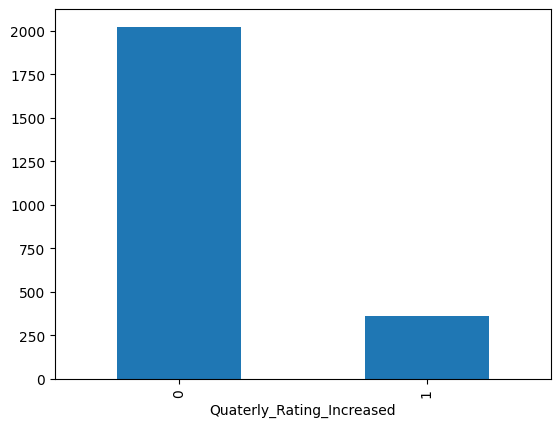

In [81]:
display(
    final_data["Quaterly_Rating_Increased"].value_counts(),
    final_data["Quaterly_Rating_Increased"]
    .value_counts(normalize=False)
    .plot(kind="bar"),
)

# observation :
# For 358 driver's quaterly rating has increased.

### 3. check wheather the monthly income has increased for a driver if it has increased than assign 1 else 0

Salary_Increased
0    2338
1      43
Name: count, dtype: int64

<Axes: xlabel='Salary_Increased'>

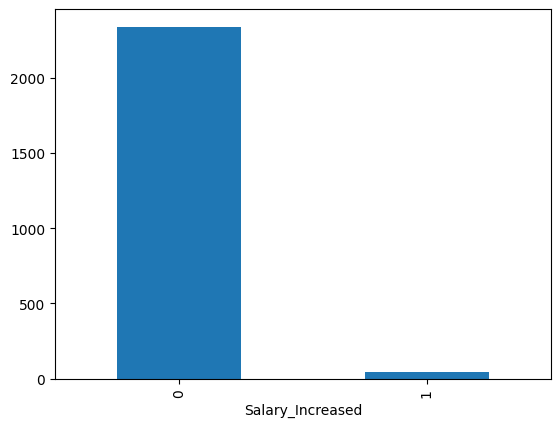

In [82]:
first_income = (
    processed_df.groupby(["Driver_ID"]).agg({"Income": "first"}).reset_index()
)
last_income = processed_df.groupby(["Driver_ID"]).agg({"Income": "last"}).reset_index()

income_change_lst = []
## Based on income changes, asign 1 and O.
for (i, first), (j, last) in zip(first_income.iterrows(), last_income.iterrows()):
    # print(
    #     f"For Driver-id :{first['Driver_ID']} : {first['Income']}----{second['Income']}"
    # )
    if first["Income"] < last["Income"]:
        income_change_lst.append(1)
    else:
        income_change_lst.append(0)

## create a new column
final_data["Salary_Increased"] = income_change_lst
display(
    final_data["Salary_Increased"].value_counts(),
    final_data["Salary_Increased"].value_counts(normalize=False).plot(kind="bar"),
)

##observation:
# for 43 drivers salary has increased

### 4. TARGET COLUMN CREATION : Driver whole last wroking day is present

Target
1    1616
0     765
Name: count, dtype: int64

<Axes: title={'center': 'Target VS Count'}, xlabel='Target'>

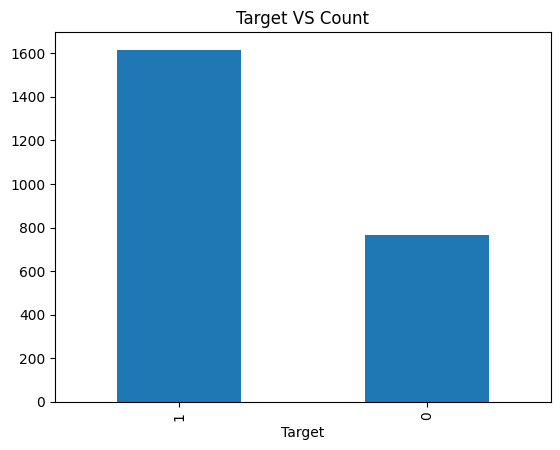

In [83]:
lwd = (
    processed_df.groupby(["Driver_ID"])
    .agg({"LastWorkingDate": "last"})["LastWorkingDate"]
    .isna()
    .reset_index()
)

lwd_lst = []
for index, row in lwd.iterrows():
    if row["LastWorkingDate"] == False:
        lwd_lst.append(1)
    else:
        lwd_lst.append(0)
final_data["Target"] = lwd_lst

display(
    final_data["Target"].value_counts(),
    final_data["Target"].value_counts().plot(kind="bar", title="Target VS Count"),
)
##Observations:
# 1. 1616 drivers stay in OLA
# 2. 765 drivers left OLA

In [84]:
final_data.describe().T
# observations :
# 1. Driver's age lie between 21 and 58.
# 2. Max. amount which driver earns is 188418.0 INR
# 3. 75% of the driver earn below 75986.0. INR

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.377018e+01,5.933265e+00,21.0,30.0,33.0,37.0,58.0
Gender,2381.0,4.105838e-01,4.914963e-01,0.0,0.0,0.0,1.0,1.0
Education_Level,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total Business Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Quarterly Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0
Last_Quarterly_Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0


### 5. Univariate Data Analysis : 

<Axes: xlabel='City'>

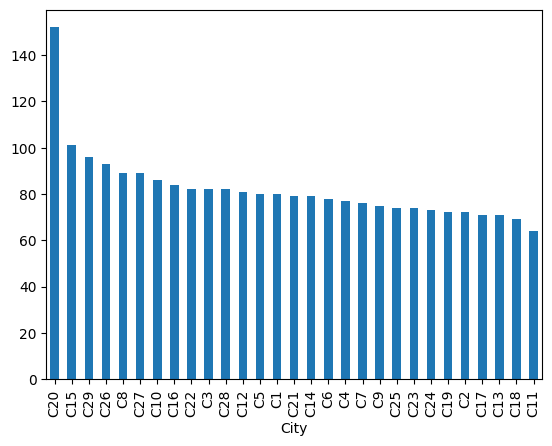

In [85]:
## Distribution of City as per rider.
final_data["City"].value_counts(normalize=False).plot(kind="bar")

## Observations:
# 1. City : C20 has maximum numbers of OLA cab drivers.

In [86]:
##Gender Male : 0 and Female : 1
final_data["Gender"].value_counts(normalize=True)

## Observations :
# 1. 58% of driver populations is Male
# 2. 40% of driver population is Female

Gender
0.0    0.587988
1.0    0.409492
0.6    0.001260
0.2    0.000840
0.4    0.000420
Name: proportion, dtype: float64

In [87]:
## Education_Level : 0 for 10+, 1 for 12+, and 2 for graduate
final_data["Education_Level"].value_counts(normalize=True)

##Observations:
# 1. 33% of driver are Graduate
# 2. 33% of drivers are 12th pass.
# 3. 32% of drivers are 10th pass.

Education_Level
2.0    0.336833
1.0    0.333893
0.0    0.329273
Name: proportion, dtype: float64

In [88]:
##Grade : Given to driver at teh time of joining
final_data["Grade"].value_counts(normalize=True)

##Observations :
# 1. 35% of driver are in grade 2.0

Grade
2.0    0.359093
1.0    0.311214
3.0    0.261655
4.0    0.057959
5.0    0.010080
Name: proportion, dtype: float64

In [89]:
##Quaterly_Rating_Increased

final_data["Quaterly_Rating_Increased"].value_counts(normalize=True)

# Observations :
# 1. For 15% of cab drivers quatrly rating has increased.
# 2. For 84% of cab drivers quatrly rating has NOT increased.

Quaterly_Rating_Increased
0    0.849643
1    0.150357
Name: proportion, dtype: float64

In [90]:
# Salary_Increased
final_data["Salary_Increased"].value_counts(normalize=True)

# Observations :
# 1. For 98% of the cab drivers salary has not increased.
# 2. For 1% of the cab drivers salary has increased.

Salary_Increased
0    0.98194
1    0.01806
Name: proportion, dtype: float64

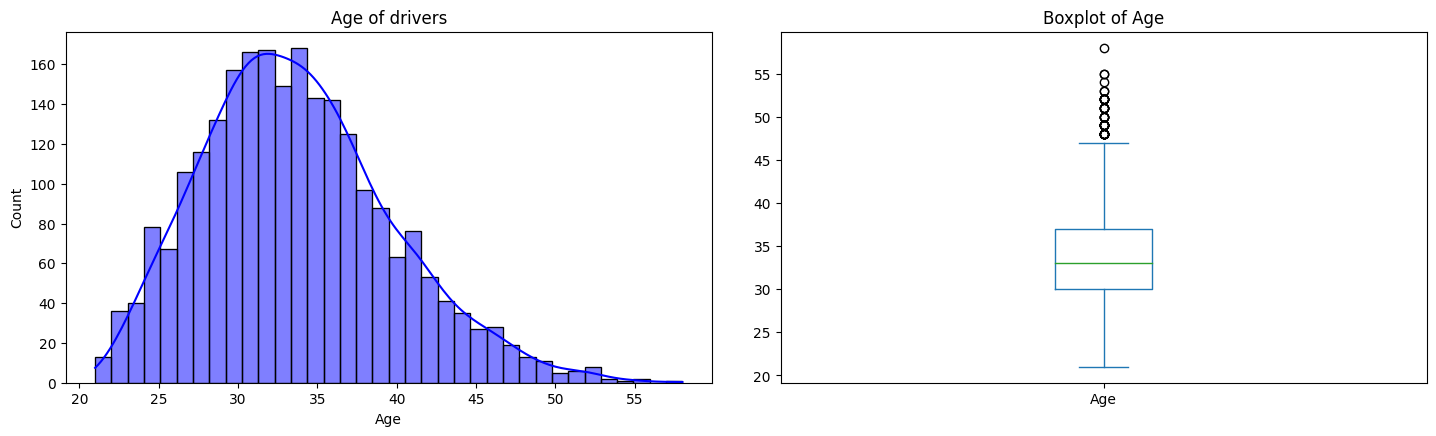

In [91]:
## Data distribution
plt.subplots(figsize=(15, 5))
plt.subplot(121)
sns.histplot(final_data["Age"], color="blue", kde=True)
plt.title("Age of drivers")
plt.subplot(122)
final_data["Age"].plot.box(title="Boxplot of Age")
plt.tight_layout(pad=3)

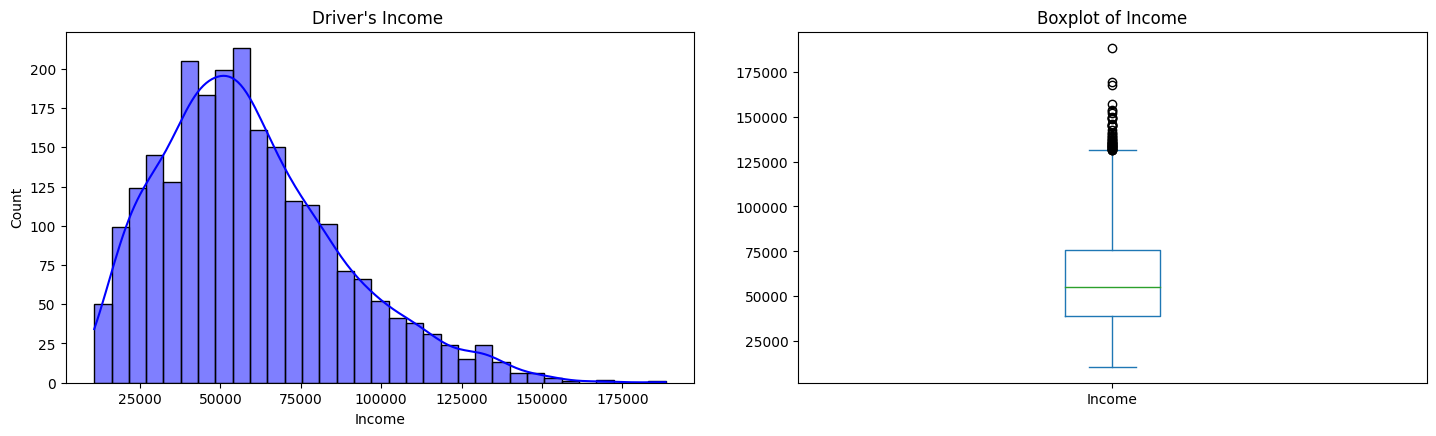

In [92]:
plt.subplots(figsize=(15, 5))
plt.subplot(121)
sns.histplot(final_data["Income"], color="blue", kde=True)
plt.title("Driver's Income ")
plt.subplot(122)
final_data["Income"].plot.box(title="Boxplot of Income")
plt.tight_layout(pad=3)

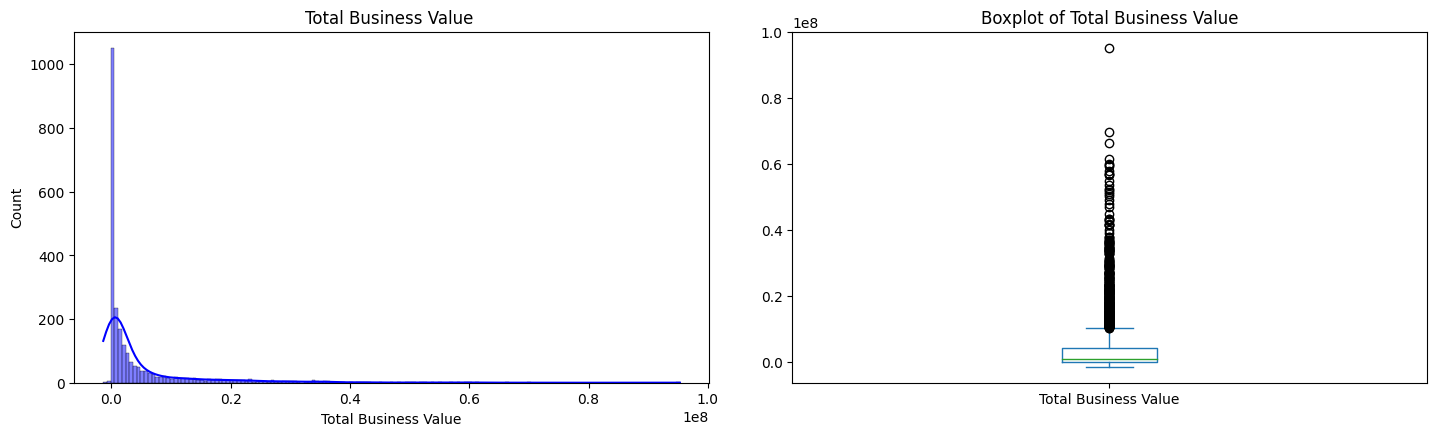

In [93]:
plt.subplots(figsize=(15, 5))
plt.subplot(121)
sns.histplot(final_data["Total Business Value"], color="blue", kde=True)
plt.title("Total Business Value ")
plt.subplot(122)
final_data["Total Business Value"].plot.box(title="Boxplot of Total Business Value")
plt.tight_layout(pad=3)

### 6. Bi-variate analysis

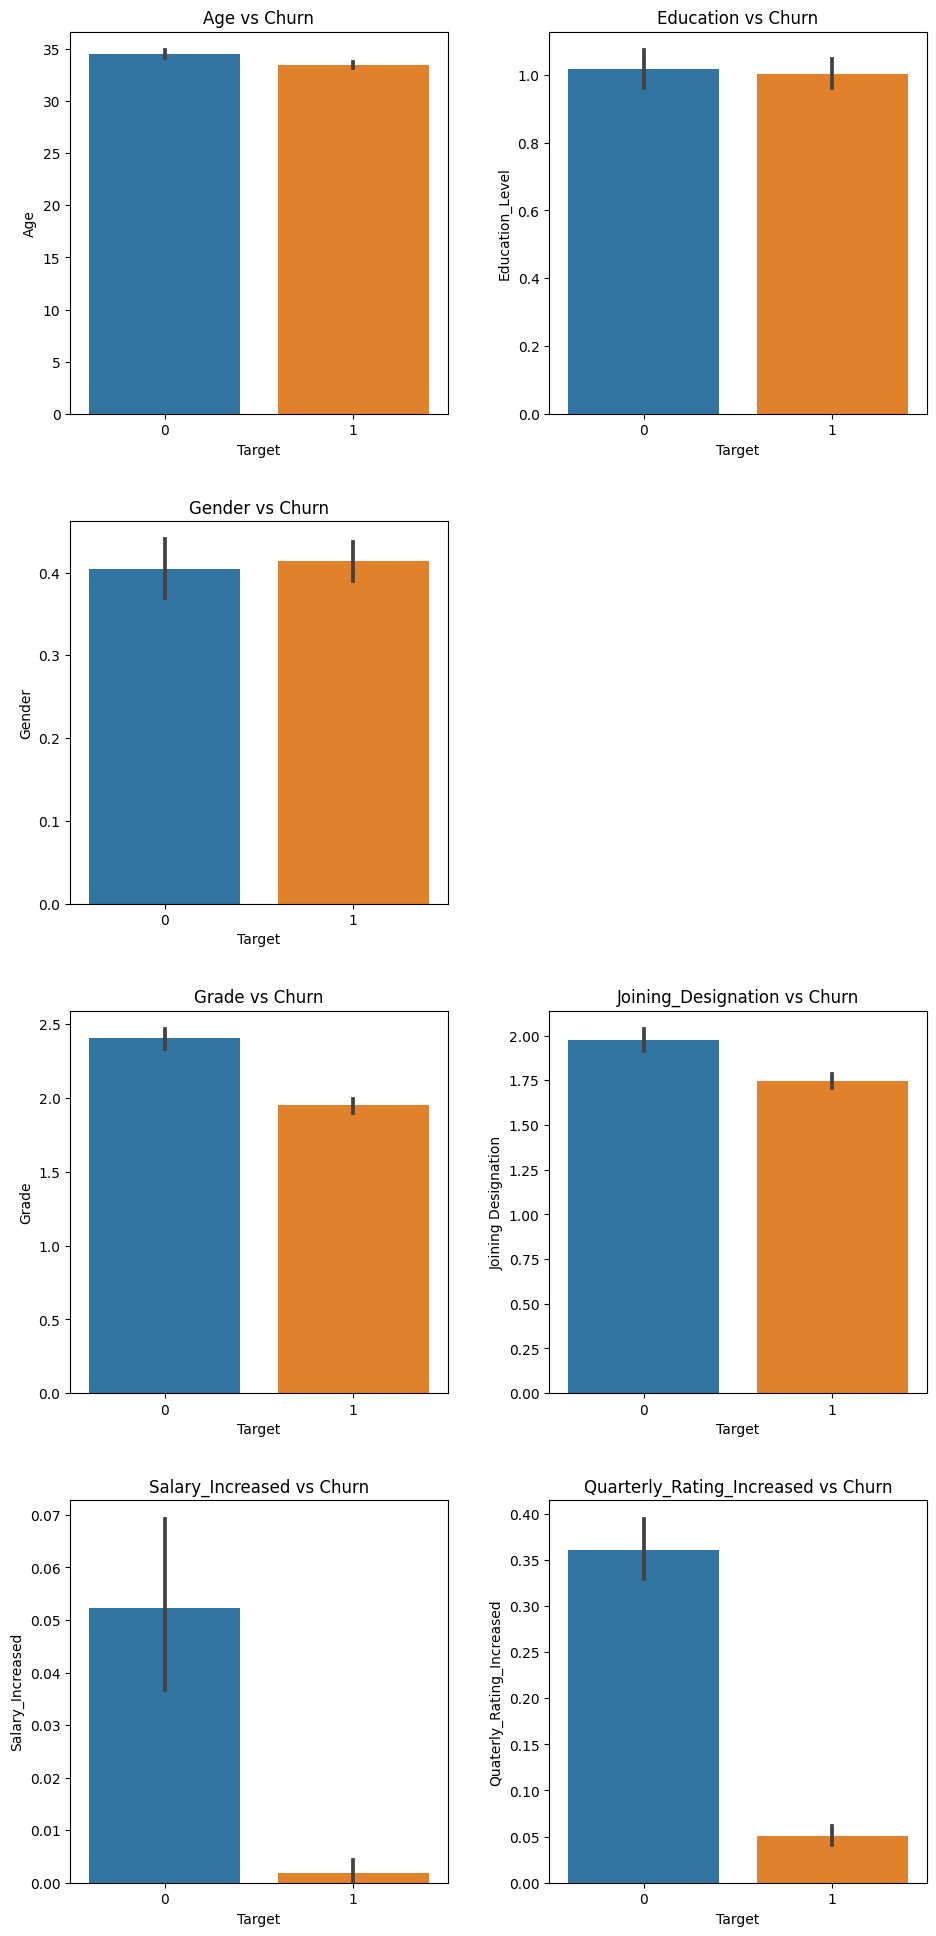

In [94]:
plt.figure(figsize=(10, 20))

plt.subplot(421)
sns.barplot(data=final_data, x="Target", y="Age")
plt.title("Age vs Churn")

plt.subplot(422)
sns.barplot(data=final_data, x="Target", y="Education_Level")
plt.title("Education vs Churn")

plt.subplot(423)
sns.barplot(data=final_data, x="Target", y="Gender")
plt.title("Gender vs Churn")

plt.subplot(425)
sns.barplot(data=final_data, x="Target", y="Grade")
plt.title("Grade vs Churn")

plt.subplot(426)
sns.barplot(data=final_data, x="Target", y="Joining Designation")
plt.title("Joining_Designation vs Churn")

plt.subplot(427)
sns.barplot(data=final_data, x="Target", y="Salary_Increased")
plt.title("Salary_Increased vs Churn")

plt.subplot(428)
sns.barplot(data=final_data, x="Target", y="Quaterly_Rating_Increased")
plt.title("Quarterly_Rating_Increased vs Churn")

plt.tight_layout(pad=3)

In [95]:
## Observations :-
# 1. Praportion of Age,Education and Gender is almost same for both the employess who left the org and who didn't.
# 2. Driver whose Salary has increased are LESS likely to leave OLA.
# 3. Driver wholse quaterly rating has NOT increased are MORE likely to LEAVE OLA.

In [96]:
final_data["Gender"].value_counts()

Gender
0.0    1400
1.0     975
0.6       3
0.2       2
0.4       1
Name: count, dtype: int64

### Impute values :

In [97]:
imputer = SimpleImputer(strategy="most_frequent")
final_data["Gender"] = imputer.fit_transform(
    X=final_data["Gender"].values.reshape(-1, 1),
    y=final_data["Target"].values.reshape(-1, 1),
)

### Target Encoding

In [98]:
te = TargetEncoder()
final_data["City"] = te.fit_transform(
    X=final_data["City"].values.reshape(-1, 1),
    y=final_data["Target"].values.reshape(-1, 1),
)

<Axes: >

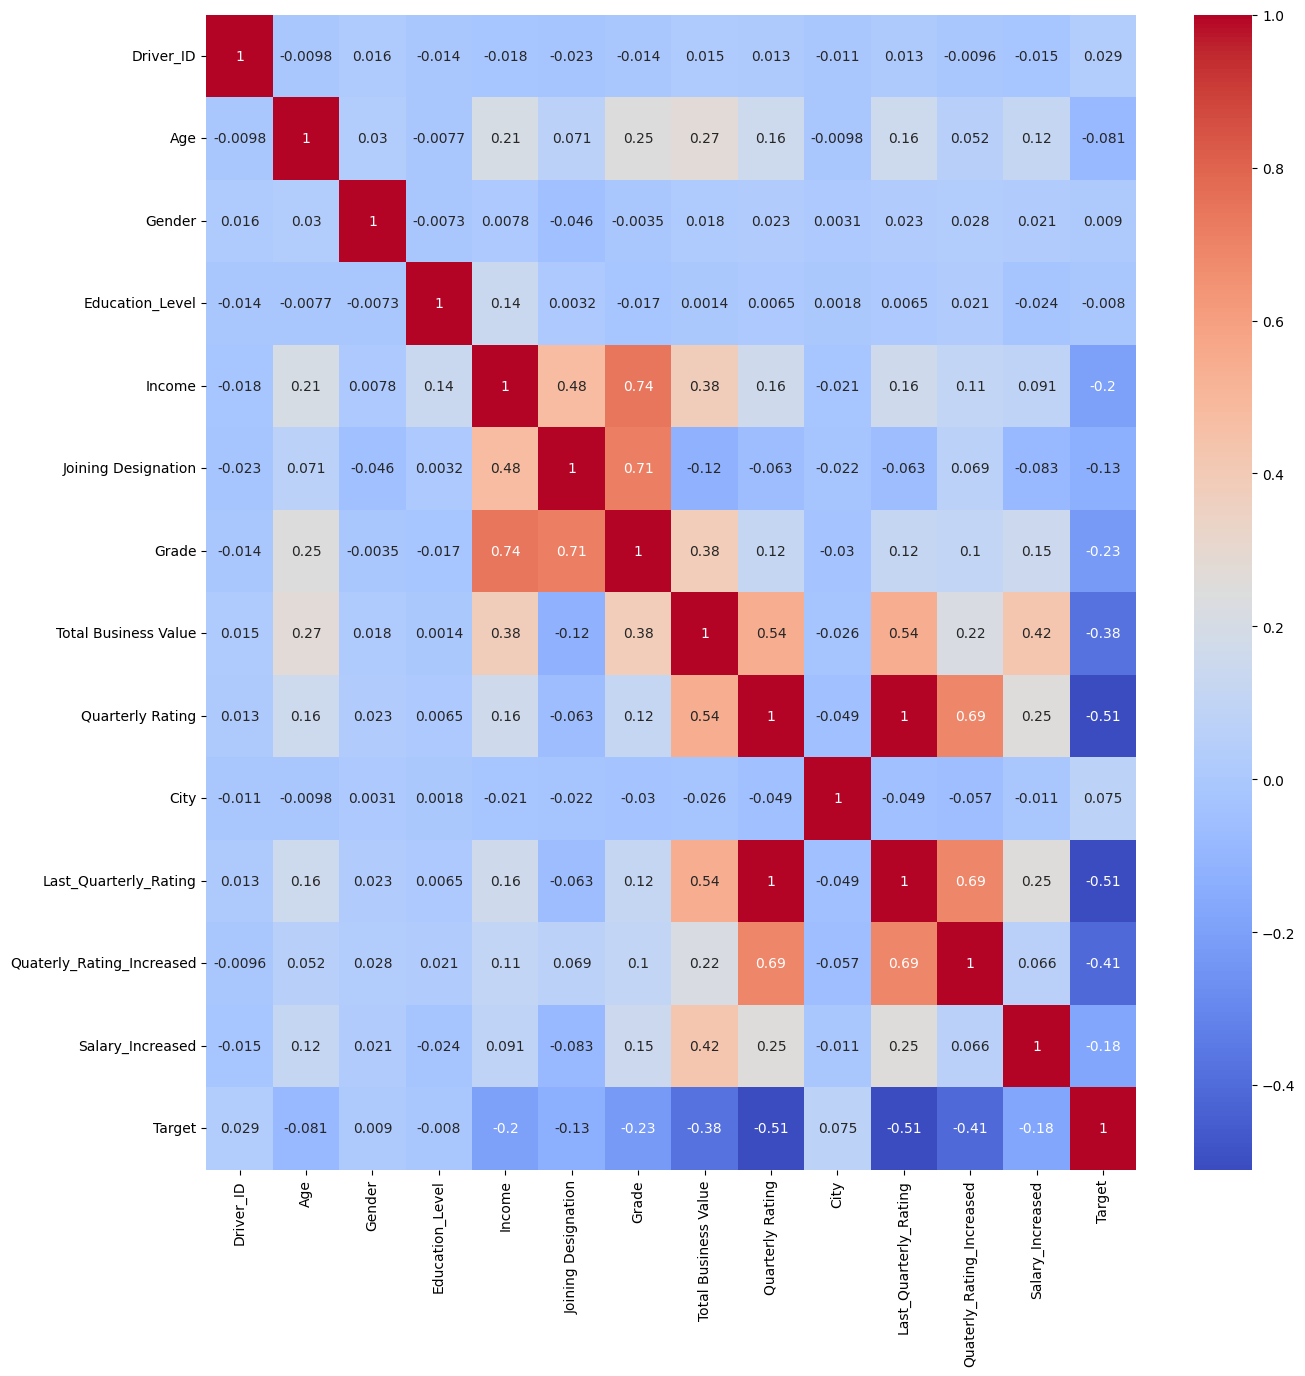

In [99]:
plt.figure(figsize=(15, 15))
sns.heatmap(final_data.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 10})

In [100]:
## Standardization

# tree-based algorithms such as decision trees, random forests and gradient boosting are not sensitive to the magnitude of variables.
# So standardization is not needed before fitting these kinds of models.

In [101]:
## Train Test split creation
x = final_data.drop(["Driver_ID", "Target"], axis=1)
y = final_data["Target"]
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=43
)

In [102]:
print(f"Size of x_train set : {len(X_train)}")
print(f"Size of x_test set : {len(X_test)}")
print(f"Size of y_train set : {len(y_train)}")
print(f"Size of y_test set : {len(y_test)}")

Size of x_train set : 1904
Size of x_test set : 477
Size of y_train set : 1904
Size of y_test set : 477


### Random Forest Classifier - Before Balancing

In [103]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced")
c = GridSearchCV(
    estimator=random_forest,
    param_grid=params,
    n_jobs=-1,
    cv=3,
    verbose=True,
    scoring="f1",
)

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 200}
Best Score:  0.8581010660648728

Elapsed Time:  5.877986192703247


              precision    recall  f1-score   support

           0       0.69      0.65      0.67       156
           1       0.83      0.86      0.85       321

    accuracy                           0.79       477
   macro avg       0.76      0.75      0.76       477
weighted avg       0.79      0.79      0.79       477



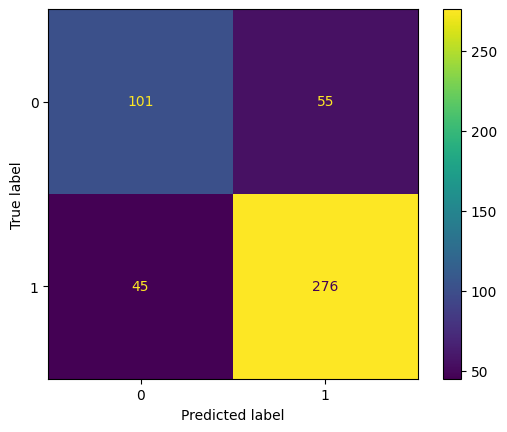

In [104]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

### Random Forest Classifier with balanced class weight

 - Out of all prediction, the measure for correctly predicted 0 is 73% and for 1 is 82% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 90% (Recall)
### As this is imbalanced dataset. We give importance to F1-Score metrics

 - F1 Score of 0 is 64%
 - F! Score of 1 is 86%

### Bootstrapped random forest using subsample

In [105]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(
    estimator=random_forest,
    param_grid=params,
    n_jobs=-1,
    cv=3,
    verbose=True,
    scoring="f1",
)

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 100}
Best Score:  0.8585268240612606

Elapsed Time:  1.682182788848877


              precision    recall  f1-score   support

           0       0.69      0.65      0.67       156
           1       0.83      0.86      0.84       321

    accuracy                           0.79       477
   macro avg       0.76      0.75      0.76       477
weighted avg       0.79      0.79      0.79       477



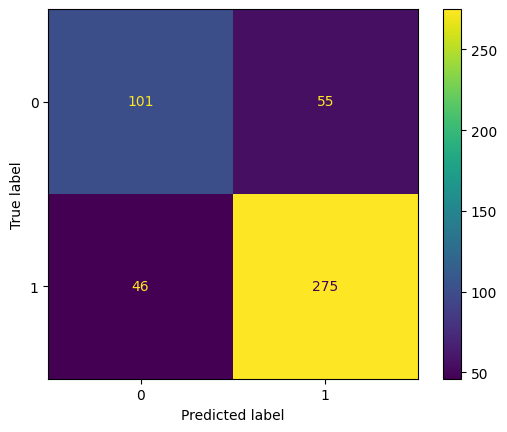

In [106]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

### Random Forest Classifier with balanced class weight

 - Out of all prediction, the measure for correctly predicted 0 is 75% and for 1 is 83% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 91% (Recall)
### As this is imbalanced dataset. We give importance to F1-Score metrics

 - F1 Score of 0 is 67%
 - F1 Score of 1 is 85%

In [107]:
### Observation : There is not much significant difference in the matrices observed for bootstrapped Random Forest and Weighted Random Forest.

### Balancing Dataset using SMOTE

In [108]:
### As the target variable is imbalanced towards 1. We will use SMOTE to balance the dataset

In [109]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state=7)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print("After OverSampling, the shape of train_X: {}".format(X_train.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1295
Before OverSampling, counts of label '0': 609 

After OverSampling, the shape of train_X: (2590, 12)
After OverSampling, the shape of train_y: (2590,) 

After OverSampling, counts of label '1': 1295
After OverSampling, counts of label '0': 1295


### Ensemble Learning: Bagging

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 50}
Best Score:  0.8094440603496134

Elapsed Time:  1.8901712894439697
              precision    recall  f1-score   support

           0       0.70      0.62      0.65       156
           1       0.82      0.87      0.85       321

    accuracy                           0.79       477
   macro avg       0.76      0.74      0.75       477
weighted avg       0.78      0.79      0.78       477



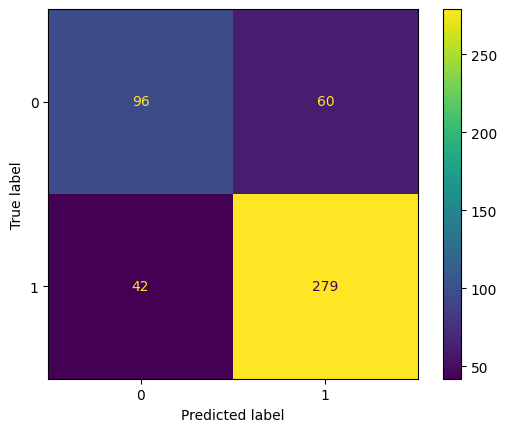

In [110]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(
    estimator=random_forest,
    param_grid=params,
    n_jobs=-1,
    cv=3,
    verbose=True,
    scoring="f1",
)

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

### Random Forest Classifier with balanced class weight

 - Out of all prediction, the measure for correctly predicted 0 is 74% and for 1 is 83% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 91% (Recall)
### As this is imbalanced dataset. We give importance to F1-Score metrics

 - F1 Score of 0 is 66%
 - F1 Score of 1 is 85%

## ROC-AUC Curve

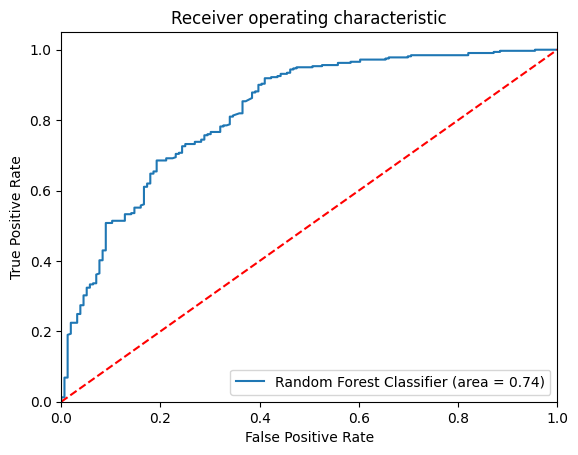

In [111]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, c.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Random Forest Classifier (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

## Ensemble Learning: Boosting

## Gradient Boosting Classifier

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Params:  {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 50, 'subsample': 1}
Best Score:  0.8359467762470851

 Elapsed Time:  51.35509943962097
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       156
           1       0.84      0.88      0.86       321

    accuracy                           0.81       477
   macro avg       0.78      0.76      0.77       477
weighted avg       0.80      0.81      0.80       477



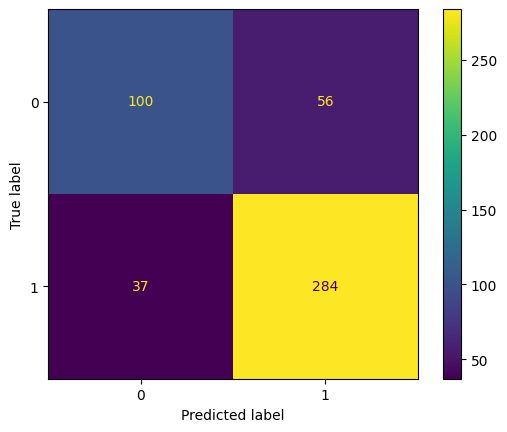

In [112]:
params = {
    "max_depth": [2, 3, 4],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 150, 200],
}

gbdt = GradientBoostingClassifier()
start_time = time.time()
c = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=True, param_grid=params)

c.fit(X_train, y_train)
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

elapsed_time = time.time() - start_time
print("\n Elapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

### Gradient Boosting Classifier Metrics

 - Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 82% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 60% and for 1 is 83% (Recall)
### As this is imbalanced dataset. We give importance to F1-Score metrics

 - F1 Score of 0 is 65%
 - F1 Score of 1 is 84%

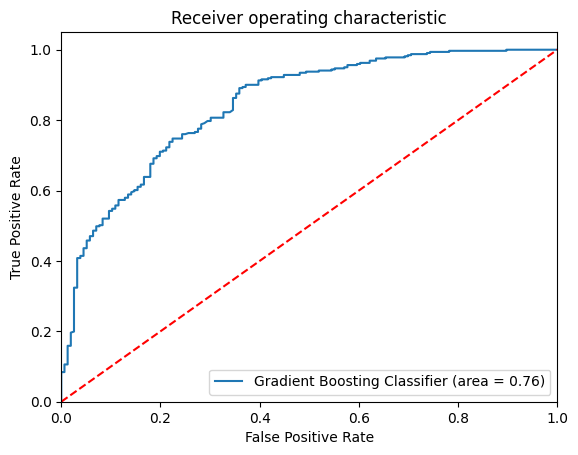

In [113]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, c.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Gradient Boosting Classifier (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

## XGBoost Classifier

XGBoost Classifier Score:  0.7819706498951782

               precision    recall  f1-score   support

           0       0.67      0.65      0.66       156
           1       0.83      0.85      0.84       321

    accuracy                           0.78       477
   macro avg       0.75      0.75      0.75       477
weighted avg       0.78      0.78      0.78       477



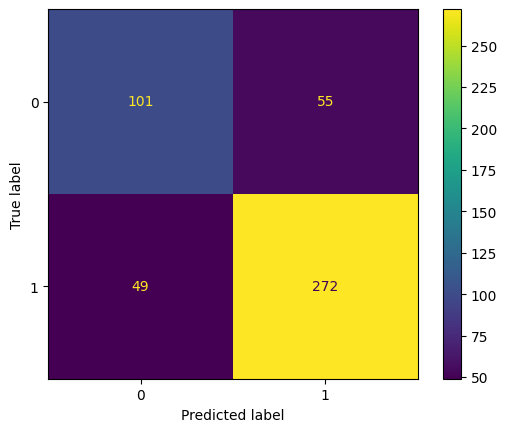

In [114]:
model = xgb.XGBClassifier(class_weight="balanced")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("XGBoost Classifier Score: ", model.score(X_test, y_test))
print("\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

### XGBoost Classifier with balanced class weight

 - Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 81% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 84% (Recall)
### As this is imbalanced dataset. We give importance to F1-Score metrics

 - F1 Score of 0 is 66%
 - F1 Score of 1 is 84%

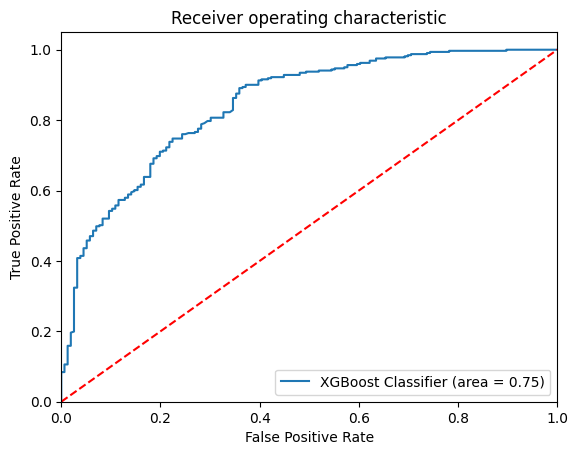

In [115]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, c.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="XGBoost Classifier (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

## Final Result Evaluation

 - We observe that we are not getting very high recall on target 0 which may be due to small unbalanced dataset.
 - Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned).
 - We observe that Random Forest with SMOTE outperforms rest of the models and has higher recall and precision values.
 - The Random Forest method out of all predicted 0 the measure of correctly predicted is 73%, and for 1 it is 82%(Precision).
 - The Random Forest method out of all actual 0 the measure of correctly predicted is 56%, and for 1 it is 91%(Recall).
 - The ROC-AUC curve area for Random Forest Classifier is 0.74
#### Gradient Boosting Classifier Result
 - Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 82% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 60% and for 1 is 83% (Recall)
 - The ROC-AUC curve area for Gradient Boosting Decision Tree Classifier is 0.71
#### XGBoost Classifier Result
 - Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 81% (Precision)
 - Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 84% (Recall)
 - The ROC-AUC curve area for XGBoost Classifier is 0.71

### Feature Importance of the best model so far.

 - Random Forest Classifier outperforms the rest of the modal.

 - Best parameters

 - Best Params: {'max_depth': 4, 'n_estimators': 50}

In [116]:
rf = RandomForestClassifier(max_depth=4, n_estimators=50, class_weight="balanced")

rf.fit(X_train, y_train)
print("Score of RandomForestClassifier: ", rf.score(X_test, y_test))

Score of RandomForestClassifier:  0.790356394129979


In [117]:
importances = rf.feature_importances_
importances

array([0.01457299, 0.03087174, 0.01112115, 0.02636594, 0.06626766,
       0.08278575, 0.15642165, 0.31345743, 0.00909937, 0.23806305,
       0.04879223, 0.00218102])

In [118]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

<Figure size 1500x700 with 0 Axes>

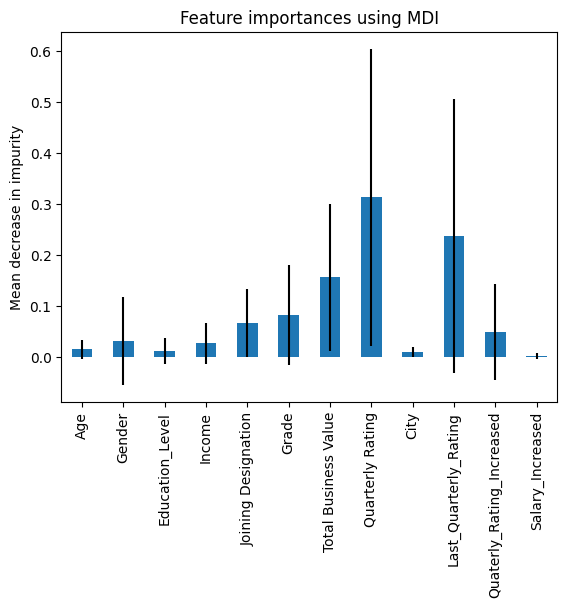

In [119]:
feature_importances = pd.Series(importances, X_train.columns)

plt.figure(figsize=(15, 7))
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

plt.show()

#### Insights

 - Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features.

#### Actionable Insights and Recommendation
 - Out of 2381 drivers 1616 have left the company.
 - We need to incentivise the drivers overtime or other perks to overcome churning
 - The employees whose quarterly rating has increased are less likely to leave the organization.
 - Company needs to implement the reward system for the customer who provide the feedback and rate drivers
 - The employees whose monthly salary has not increased are more likely to leave the organization.
 - Company needs to get in touch with those drivers whose monthly salary has not increased and help them out to earn more by provider bonus and perks.
 - Out of 2381 employees, 1744 employees had their last quarterly rating as 1.
 - Out of 2381 employees, the quarterly rating has not increased for 2076 employees. This is red flag for the company which needs to regulate.
 - Company needs to look why customers are not rating drivers.
 - Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features. Company needs to tracks these features as predicators
 - We observe that we are not getting very high recall on target 0 which may be due to small unbalanced dataset. More data will overcome this issue.
 - The Random Forest Classifier attains the Recall score of 91% for the driver who left the company. Which indicates that model is performing the decent job.